In [33]:
from data_processing import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import numpy as np
from noise import NoiseScheduler
import torch
from jet_finding import *

In [34]:
baseDir='/hdfs/user/ys20884/hackathon/data'
dataset = Dataset(10000, (120, 72), signal_file=f"{baseDir}/CaloImages_signal.root", pile_up_file=f"{baseDir}/CaloImages_bkg.root", save=False)

In [35]:
dataset() #once this is cached, you don't have to re-load

INFO:root:loading file /hdfs/user/ys20884/hackathon/data/CaloImages_signal.root
loading file /hdfs/user/ys20884/hackathon/data/CaloImages_signal.root
100%|██████████| 10000/10000 [00:17<00:00, 574.01it/s]
INFO:root:loading file /hdfs/user/ys20884/hackathon/data/CaloImages_bkg.root
loading file /hdfs/user/ys20884/hackathon/data/CaloImages_bkg.root
100%|██████████| 10000/10000 [00:17<00:00, 555.75it/s]


In [36]:
new_dim=(64,64)

dataset.preprocess(16, new_dim)

INFO:root:scaling
scaling
INFO:root:re-sizing
re-sizing


In [37]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

In [38]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)

In [39]:
print (clean_frames[0].sum())
clean_frames[clean_frames!=0] = 0
print (clean_frames[0].sum())

tensor(15.1939)
tensor(0.)


In [40]:
noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([40]) #each unit of timestep represents an addtional 5 pile-up events
n_events = 10000
noisy_images = []
for clean_frame in clean_frames:
    random_seed = np.random.randint(0, n_events)
    noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frame, noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = n_events)
    noisy_images.append(noisy_image)


In [41]:
from models import Model

model = Model('UNet-lite', new_dim)

model = model.__getitem__()

trained_model_path = 'trained_models_lite/model_epoch_9.pt'

checkpoint = torch.load(trained_model_path)

model.load_state_dict(checkpoint)

denoised_images = []
jets_noisy_allEvents = []
jets_denoised_allEvents = []
for noisy_image in noisy_images:
    noise_pred = model(noisy_image.unsqueeze(1), timestep)

    de_noised = noisy_image - noise_pred.detach().numpy().reshape(new_dim)
    denoised_images.append(de_noised)

    local_maxima, jets_noisy = find_local_maxima( noisy_image.unsqueeze(1).reshape(new_dim), 9 )
    jets_noisy_allEvents.append(jets_noisy)
    local_maxima, jets_denoised = find_local_maxima( de_noised.unsqueeze(1).reshape(new_dim), 9 )
    jets_denoised_allEvents.append(jets_denoised)


In [ ]:

print (jets_noisy_allEvents[0])
print (jets_denoised_allEvents[0])

[{'i': 0, 'j': 17, 'pixel_value': tensor(0.4136), 'sum_around_maxima': 4.218757}, {'i': 4, 'j': 9, 'pixel_value': tensor(0.3407), 'sum_around_maxima': 7.2260785}, {'i': 4, 'j': 50, 'pixel_value': tensor(0.5644), 'sum_around_maxima': 7.4337635}, {'i': 5, 'j': 0, 'pixel_value': tensor(0.5985), 'sum_around_maxima': 5.160993}, {'i': 7, 'j': 45, 'pixel_value': tensor(0.6870), 'sum_around_maxima': 6.686359}, {'i': 7, 'j': 61, 'pixel_value': tensor(0.4451), 'sum_around_maxima': 6.134974}, {'i': 8, 'j': 27, 'pixel_value': tensor(0.4118), 'sum_around_maxima': 7.686881}, {'i': 10, 'j': 52, 'pixel_value': tensor(0.7030), 'sum_around_maxima': 8.439137}, {'i': 11, 'j': 40, 'pixel_value': tensor(0.4898), 'sum_around_maxima': 6.413879}, {'i': 13, 'j': 3, 'pixel_value': tensor(0.4459), 'sum_around_maxima': 7.017827}, {'i': 17, 'j': 34, 'pixel_value': tensor(0.5046), 'sum_around_maxima': 6.2163334}, {'i': 20, 'j': 17, 'pixel_value': tensor(0.6922), 'sum_around_maxima': 6.629595}, {'i': 22, 'j': 25, 'pi

In [ ]:
leading_jet_noisy = []
leading_jet_denoised = []
print (jets_denoised_allEvents[0])
for event in jets_noisy_allEvents:
#     print (event)
    max_pt_jet = max(event, key=lambda x: x['sum_around_maxima'])
    
    # Append the max pt jet to the result list
    leading_jet_noisy.append(max_pt_jet)

for event in jets_denoised_allEvents:
    max_pt_jet = max(event, key=lambda x: x['sum_around_maxima'])
    
    # Append the max pt jet to the result list
    leading_jet_denoised.append(max_pt_jet)


[{'i': 5, 'j': 0, 'pixel_value': tensor(0.3567), 'sum_around_maxima': 1.6267664}, {'i': 7, 'j': 45, 'pixel_value': tensor(0.3460), 'sum_around_maxima': 0.20833567}, {'i': 10, 'j': 52, 'pixel_value': tensor(0.3436), 'sum_around_maxima': 1.9092823}, {'i': 20, 'j': 17, 'pixel_value': tensor(0.3414), 'sum_around_maxima': 0.48475605}, {'i': 29, 'j': 17, 'pixel_value': tensor(0.4459), 'sum_around_maxima': 1.4318268}, {'i': 45, 'j': 33, 'pixel_value': tensor(0.3507), 'sum_around_maxima': 0.4363739}, {'i': 59, 'j': 28, 'pixel_value': tensor(0.3366), 'sum_around_maxima': 0.85852754}]


In [ ]:
print (leading_jet_noisy)

[{'i': 10, 'j': 52, 'pixel_value': tensor(0.7030), 'sum_around_maxima': 8.439137}, {'i': 19, 'j': 13, 'pixel_value': tensor(0.3663), 'sum_around_maxima': 6.881389}, {'i': 28, 'j': 11, 'pixel_value': tensor(0.4828), 'sum_around_maxima': 9.080712}, {'i': 39, 'j': 7, 'pixel_value': tensor(0.8270), 'sum_around_maxima': 8.295656}, {'i': 44, 'j': 39, 'pixel_value': tensor(0.5219), 'sum_around_maxima': 7.7903805}, {'i': 59, 'j': 34, 'pixel_value': tensor(0.6494), 'sum_around_maxima': 8.095516}, {'i': 22, 'j': 10, 'pixel_value': tensor(1.2192), 'sum_around_maxima': 9.6005335}, {'i': 57, 'j': 28, 'pixel_value': tensor(0.3726), 'sum_around_maxima': 8.164745}, {'i': 36, 'j': 52, 'pixel_value': tensor(0.4122), 'sum_around_maxima': 8.873458}, {'i': 38, 'j': 12, 'pixel_value': tensor(0.6120), 'sum_around_maxima': 7.350028}, {'i': 42, 'j': 27, 'pixel_value': tensor(0.3953), 'sum_around_maxima': 9.556179}, {'i': 51, 'j': 33, 'pixel_value': tensor(0.7414), 'sum_around_maxima': 7.796463}, {'i': 43, 'j':

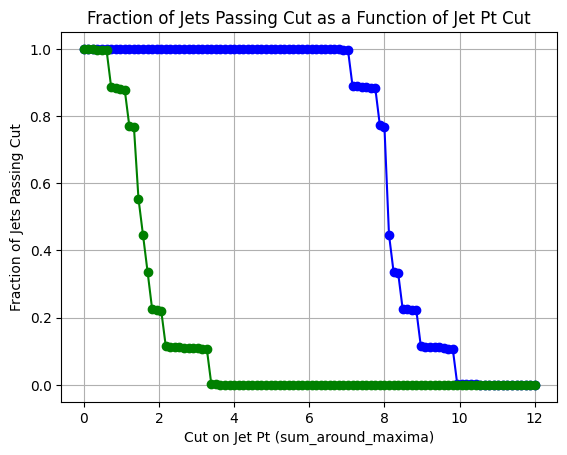

In [ ]:
cut_values = np.linspace(0, 12, 100)

pt_values_noisy = [jet['sum_around_maxima'] for jet in leading_jet_noisy]
fraction_passing_noisy = [sum(pt >= cut for pt in pt_values_noisy) / len(pt_values_noisy) for cut in cut_values]

pt_values_denoised = [jet['sum_around_maxima'] for jet in leading_jet_denoised]
fraction_passing_denoised = [sum(pt >= cut for pt in pt_values_denoised) / len(pt_values_denoised) for cut in cut_values]

plt.plot(cut_values, fraction_passing_noisy, marker='o', linestyle='-', color='b')
plt.plot(cut_values, fraction_passing_denoised, marker='o', linestyle='-', color='g')
plt.xlabel('Cut on Jet Pt (sum_around_maxima)')
plt.ylabel('Fraction of Jets Passing Cut')
plt.title('Fraction of Jets Passing Cut as a Function of Jet Pt Cut')
plt.grid(True)
plt.show()